In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install -q -U ultralytics wandb
!pip install -q -U ipywidgets # To avoid a future warning
!wandb off
!pip install python-dotenv

W&B offline. Running your script from this directory will only write metadata locally. Use wandb disabled to completely turn off W&B.


In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!echo '{"username":"adityakurdunkar","key":"675e76ea420e1052eac832c5b04ed9b5"}' > ~/.kaggle/kaggle.json
!cat ~/.kaggle/kaggle.json
!kaggle competitions download -c global-wheat-detection
!unzip global-wheat-detection.zip -d datasets

mkdir: cannot create directory ‘/root/.kaggle’: File exists
{"username":"adityakurdunkar","key":"675e76ea420e1052eac832c5b04ed9b5"}
... resuming from 636694264 bytes (0 bytes left) ...
416 - Requested range not satisfiable
Archive:  global-wheat-detection.zip
replace datasets/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!echo "PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True" > .env

In [ ]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

# Data Preprocessing
import os, yaml, ast
import pandas as pd
import numpy as np
from tqdm import tqdm
from shutil import copyfile
from sklearn.model_selection import train_test_split

# Visualization
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

# Model
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')

Ultralytics YOLOv8.2.18 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.0/78.2 GB disk)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


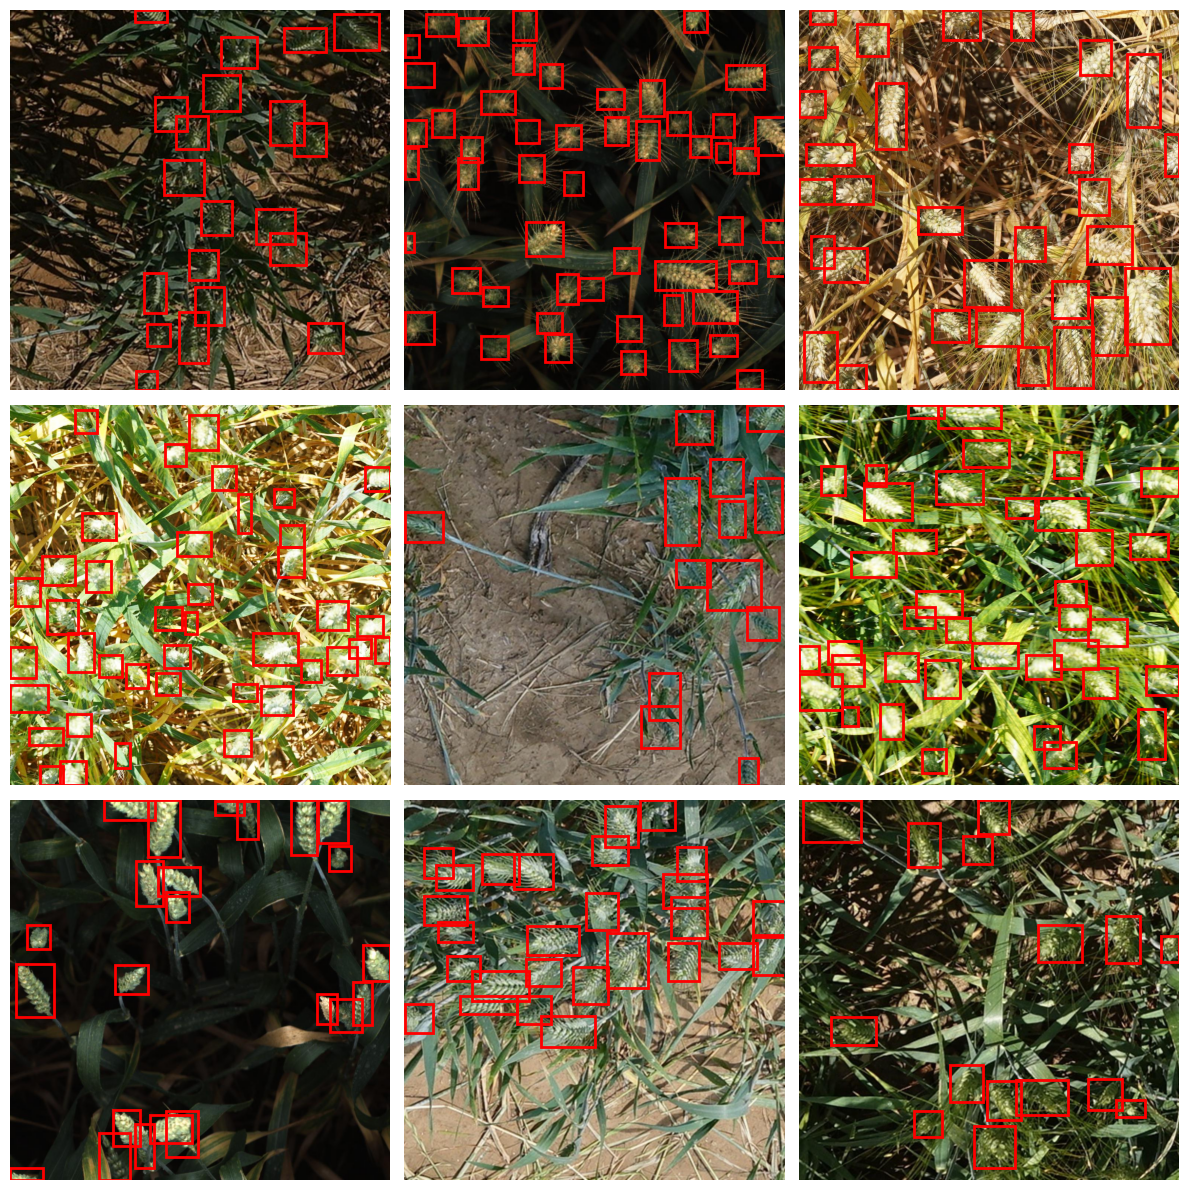

In [ ]:
# Defining root folder
root = 'datasets/'

# Loading dataset
data = pd.read_csv(root + 'train.csv', usecols = ['image_id', 'bbox'])

# Creating column 'path' to store file path
data['path'] = data.apply(lambda row : root + 'train/' + row.image_id + '.jpg', axis = 1)

# Converting bounding boxes to list datatype
data['bbox'] = data['bbox'].apply(ast.literal_eval)

data.head()

def display_image_with_boxes():
    # Shuffling the list of unique image paths
    uniqueImages = data['path'].unique()
    np.random.shuffle(uniqueImages)

    # Determining max number of images to display (9 here)
    numImages = min(len(uniqueImages), 9)
    rows = cols = 3

    # Creating subplots
    fig, axes = plt.subplots(rows, cols, figsize = (12, 12))

    for i, imgPath in enumerate(uniqueImages[:numImages]):
        # Reading image and converting to RGB
        img = cv2.imread(imgPath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Getting all bounding boxes for current image
        boxes = data[data['path'] == imgPath]['bbox'].tolist()
        for box in boxes:
            x, y, w, h = box

            # Adding rectangle patch to current subplot
            rect = patches.Rectangle((x, y), w, h, linewidth = 2, edgecolor = 'r', facecolor = 'none')
            axes[i // cols, i % cols].add_patch(rect)

        # Displaying image and turning off axis labels
        axes[i // cols, i % cols].imshow(img)
        axes[i // cols, i % cols].axis('off')

    plt.tight_layout()
    plt.show()

display_image_with_boxes()

In [ ]:
# Train-validation split
trainList, valList = train_test_split(data.image_id.unique(), random_state = 0)

# Filtering out train and validation data
trainDf = data.loc[data.image_id.isin(trainList)]
valDf = data.loc[data.image_id.isin(valList)]

trainDf.loc[:, 'split'] = 'train'
valDf.loc[:, 'split'] = 'valid'

# Concatenating the training and validation datasets
data = pd.concat([trainDf, valDf]).reset_index(drop = True)
data.head()

# Creating necessary directories for images and labels
os.makedirs(f'{root}/images/train', exist_ok = True)
os.makedirs(f'{root}/images/valid', exist_ok = True)

os.makedirs(f'{root}/labels/train', exist_ok = True)
os.makedirs(f'{root}/labels/valid', exist_ok = True)

# Copying training and validation images to new folder
for i in tqdm(range(len(data))):
    row = data.loc[i]
    copyfile(row.path, f'{root}/images/{row.split}/{row.image_id}.jpg')

# Creating the yaml file required for YOLO
content = '''
path: '.'

train: 'images/train'
val: 'images/valid'

names:
    0: none
    1: opacity
'''

with open('GlobalWheatDataset.yaml', 'w') as file:
    file.write(content)

# Function to create YOLO-formatted bounding boxes
def createYOLOBox(bbox):
    # Unpacking coordinates from list
    x, y, w, h = bbox

    # Normalizing coordinates
    x_center = (x + w / 2) / 1024
    y_center = (y + h / 2) / 1024

    return f'1 {x_center} {y_center} {w / 1024} {h / 1024}'

# Creating text file for each image containing required bounding box coordinates
for i in tqdm(range(len(data))):
    row = data.loc[i]
    yoloBox = createYOLOBox(row['bbox'])

    # Defining file path
    filePath = f'{root}/labels/{row.split}/{row.image_id}.txt'
    with open(filePath, 'a') as file:
        file.write(yoloBox + '\n')

In [ ]:
# Loading pre-trained YOLOv8n model
model = YOLO('/content/runs/detect/train/weights/last.pt')
model.info()

# Training the model
results = model.train(
    data = 'GlobalWheatDataset.yaml',
    epochs = 100,
    batch = 32,
    imgsz = 1024,
    optimizer = 'Adam',
    cos_lr = True,
    dropout = 0.2,
    device = [0],
    resume = True
)

# Loading the metrics JPG file
img = mpimg.imread('./train/results.png')

# Displaying the image
plt.figure(figsize = (30, 30))
plt.imshow(img)
plt.axis('off')
plt.show()

Model summary: 225 layers, 3011238 parameters, 0 gradients, 8.2 GFLOPs
Ultralytics YOLOv8.2.18 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/last.pt, data=GlobalWheatDataset.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=1024, save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=/content/runs/detect/train/weights/last.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fa

train: Scanning /content/datasets/labels/train.cache... 2528 images, 0 backgrounds, 1 corrupt: 100%|██████████| 2529/2529 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/datasets/images/train/1c0155c9c.jpg: ignoring corrupt image/label: image file is truncated (20 bytes not processed)


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/labels/valid.cache... 844 images, 0 backgrounds, 0 corrupt: 100%|██████████| 844/844 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Resuming training /content/runs/detect/train/weights/last.pt from epoch 33 to 100 total epochs
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      14.6G      1.556     0.8073      1.616       1724       1024: 100%|██████████| 79/79 [02:54<00:00,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:31<00:00,  2.24s/it]


                   all        844      36437      0.853      0.792      0.871      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      13.8G      1.596     0.8362      1.513       1995       1024: 100%|██████████| 79/79 [02:51<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:25<00:00,  1.84s/it]


                   all        844      36437      0.883      0.827      0.901      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      14.4G      1.577     0.8242      1.427       1404       1024: 100%|██████████| 79/79 [03:03<00:00,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:26<00:00,  1.90s/it]


                   all        844      36437      0.877      0.782      0.867      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      15.1G      1.566     0.8134      1.398       2687       1024: 100%|██████████| 79/79 [02:47<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:33<00:00,  2.37s/it]


                   all        844      36437      0.859      0.808      0.881      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      13.8G      1.557     0.8021      1.393       1744       1024: 100%|██████████| 79/79 [02:45<00:00,  2.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:25<00:00,  1.82s/it]


                   all        844      36437      0.891       0.84      0.901      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      13.7G      1.559     0.7987      1.416       1885       1024: 100%|██████████| 79/79 [02:50<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:26<00:00,  1.91s/it]


                   all        844      36437      0.888      0.838      0.907      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      13.8G      1.558     0.8055      1.431       1848       1024: 100%|██████████| 79/79 [02:47<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:28<00:00,  2.01s/it]


                   all        844      36437      0.879      0.816      0.895      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      13.9G      1.563     0.7999      1.419       1815       1024: 100%|██████████| 79/79 [02:47<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:29<00:00,  2.08s/it]


                   all        844      36437      0.847      0.715        0.8      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      13.5G      1.574     0.8132      1.395       2096       1024: 100%|██████████| 79/79 [02:46<00:00,  2.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:25<00:00,  1.79s/it]


                   all        844      36437      0.899      0.854      0.919      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      14.1G      1.554     0.7897      1.428       1975       1024: 100%|██████████| 79/79 [02:51<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:28<00:00,  2.00s/it]


                   all        844      36437      0.877      0.835      0.901      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      14.3G      1.569     0.8153      1.456       1965       1024: 100%|██████████| 79/79 [02:54<00:00,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:25<00:00,  1.84s/it]


                   all        844      36437      0.909      0.843      0.916      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      13.6G      1.544     0.7894      1.384       1881       1024: 100%|██████████| 79/79 [02:55<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:25<00:00,  1.85s/it]


                   all        844      36437      0.884      0.843      0.911      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      15.5G      1.562     0.8041      1.447       2272       1024: 100%|██████████| 79/79 [02:55<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


                   all        844      36437      0.871      0.799       0.88      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      14.1G       1.56     0.7999      1.441       1527       1024: 100%|██████████| 79/79 [02:51<00:00,  2.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:25<00:00,  1.79s/it]


                   all        844      36437      0.888      0.825        0.9      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      14.6G      1.553     0.7982      1.386       1759       1024: 100%|██████████| 79/79 [03:01<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:24<00:00,  1.77s/it]


                   all        844      36437      0.895      0.839      0.909      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      13.7G      1.537     0.7781      1.379       1705       1024: 100%|██████████| 79/79 [02:55<00:00,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:31<00:00,  2.28s/it]


                   all        844      36437      0.904      0.846      0.921      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      14.1G      1.538     0.7798      1.445       2011       1024: 100%|██████████| 79/79 [02:54<00:00,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:27<00:00,  1.93s/it]


                   all        844      36437      0.882       0.83      0.903      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      13.8G      1.549     0.7839      1.389       2037       1024: 100%|██████████| 79/79 [02:58<00:00,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:26<00:00,  1.90s/it]


                   all        844      36437      0.914      0.855      0.927      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      14.2G       1.53     0.7688      1.368       1918       1024: 100%|██████████| 79/79 [02:55<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:25<00:00,  1.81s/it]


                   all        844      36437      0.893       0.86      0.919      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      13.6G      1.532     0.7702       1.39       1313       1024: 100%|██████████| 79/79 [03:06<00:00,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:44<00:00,  3.15s/it]


                   all        844      36437      0.908      0.865      0.929      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      13.6G      1.509     0.7557       1.35       1804       1024: 100%|██████████| 79/79 [03:09<00:00,  2.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:27<00:00,  1.98s/it]


                   all        844      36437      0.911      0.868      0.929       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100        14G       1.51     0.7515      1.406       1693       1024: 100%|██████████| 79/79 [02:48<00:00,  2.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:28<00:00,  2.06s/it]


                   all        844      36437      0.902      0.874      0.929      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      13.6G      1.527     0.7665      1.377       2071       1024: 100%|██████████| 79/79 [02:54<00:00,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:28<00:00,  2.03s/it]


                   all        844      36437      0.902      0.867      0.929      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      14.6G      1.506     0.7483      1.354       1725       1024: 100%|██████████| 79/79 [02:57<00:00,  2.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:25<00:00,  1.80s/it]


                   all        844      36437      0.903      0.871       0.93      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      13.4G      1.517     0.7532      1.375       1785       1024: 100%|██████████| 79/79 [02:54<00:00,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:28<00:00,  2.02s/it]


                   all        844      36437      0.912      0.867      0.932      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      14.1G      1.513     0.7448      1.355       1865       1024: 100%|██████████| 79/79 [02:54<00:00,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


                   all        844      36437      0.913      0.869      0.933      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      14.4G      1.507     0.7375      1.381       1934       1024: 100%|██████████| 79/79 [02:55<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


                   all        844      36437      0.913      0.874      0.936      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      13.7G      1.504     0.7408      1.366       2111       1024: 100%|██████████| 79/79 [02:55<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:26<00:00,  1.87s/it]


                   all        844      36437      0.905       0.87      0.929      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      14.1G      1.502     0.7403      1.357       1914       1024: 100%|██████████| 79/79 [02:47<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:33<00:00,  2.40s/it]


                   all        844      36437      0.909      0.879      0.937       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100        14G      1.489     0.7259      1.339       1726       1024: 100%|██████████| 79/79 [02:47<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:25<00:00,  1.83s/it]


                   all        844      36437       0.91       0.88      0.937      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      13.9G      1.495     0.7416      1.336       1680       1024:   8%|▊         | 6/79 [00:09<01:55,  1.58s/it]


KeyboardInterrupt: 

In [ ]:
# Creating best-weighted model
bestModel = YOLO('runs/detect/train/weights/best.pt')

# Making predictions on test set
results = bestModel.predict(
    source = f'{root}/test',
    imgsz = 1024,
    conf = 0.65,
    iou = 0.65,
    save_txt = True,
    save_conf = True
)

import cv2
from ultralytics.utils.plotting import Annotator
from google.colab.patches import cv2_imshow

for r in results:
      # Reading image and converting to RGB
    _img = cv2.imread(r.path)

    annotator = Annotator(_img)

    boxes = r.boxes
    for box in boxes:

        b = box.xyxy[0]  # get box coordinates in (left, top, right, bottom) format
        c = box.cls
        annotator.box_label(b, model.names[int(c)])

    img = annotator.result()
    cv2_imshow(img)